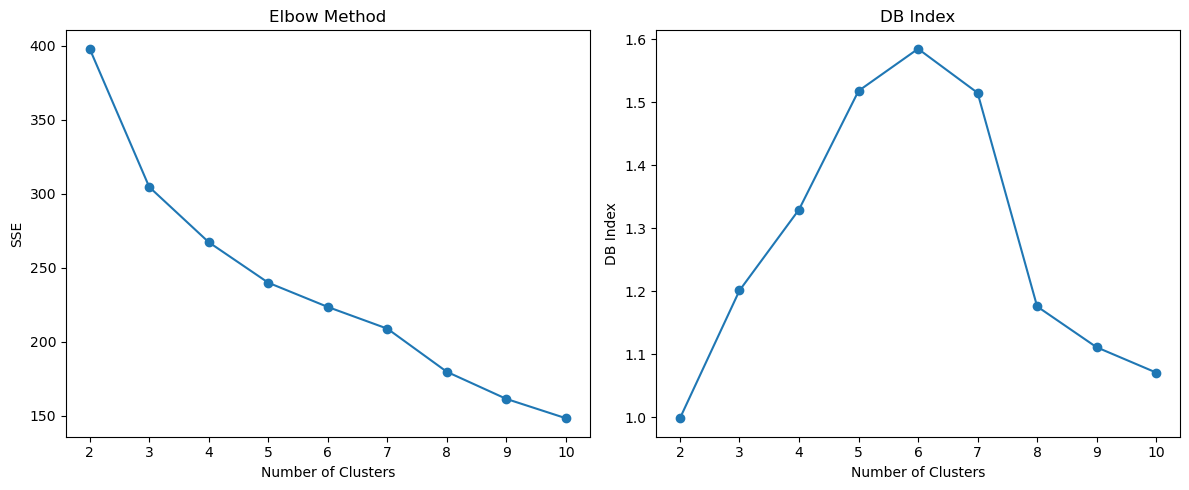

DB Index: 1.3297933543305485
Silhouette Score: 0.22324932997180805


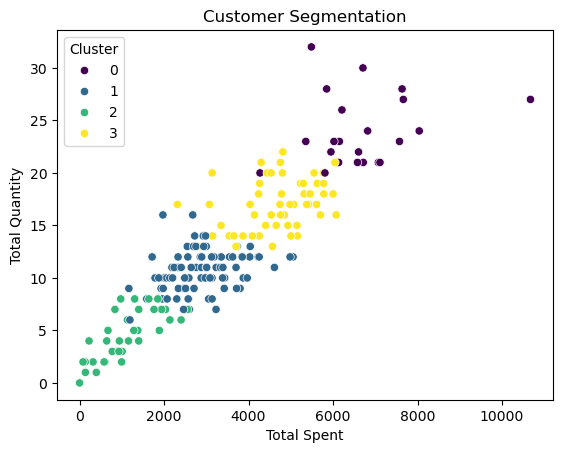

Clustered data saved as 'FirstName_LastName_Clustering.csv'


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_path = 'Downloads/Customers.csv'
transactions_path = 'Downloads/Transactions.csv'

customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

# Aggregate transaction data
customer_transactions = transactions_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    unique_products=('ProductID', 'nunique')
).reset_index()

# Merge datasets
customer_data = pd.merge(customers_df, customer_transactions, on="CustomerID", how="left")
customer_data.fillna(0, inplace=True)

# Preprocessing: One-hot encode Region, scale numerical features
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_data[['Region']]).toarray()
region_columns = encoder.get_feature_names_out(['Region'])

numerical_features = ['total_spent', 'total_quantity', 'unique_products']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[numerical_features])

# Combine all features
final_data = pd.concat(
    [pd.DataFrame(region_encoded, columns=region_columns), pd.DataFrame(scaled_features, columns=numerical_features)],
    axis=1
)

# Determine optimal number of clusters using Elbow Method and DB Index
db_scores = []
sse = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_data)
    cluster_labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(final_data, cluster_labels))
    sse.append(kmeans.inertia_)

# Plot Elbow Method and DB Index
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('DB Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.tight_layout()
plt.show()

# Final Clustering with optimal clusters (e.g., k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(final_data)

# Evaluate Clustering
db_index = davies_bouldin_score(final_data, customer_data['Cluster'])
sil_score = silhouette_score(final_data, customer_data['Cluster'])

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

# Visualization: Scatterplot for clusters
sns.scatterplot(
    x=customer_data['total_spent'],
    y=customer_data['total_quantity'],
    hue=customer_data['Cluster'],
    palette='viridis'
)
plt.title('Customer Segmentation')
plt.xlabel('Total Spent')
plt.ylabel('Total Quantity')
plt.legend(title='Cluster')
plt.show()

# Save clustered data
customer_data.to_csv('FirstName_LastName_Clustering.csv', index=False)
print("Clustered data saved as 'FirstName_LastName_Clustering.csv'")
